# Datenvisualisierung auf Landkarten mit Python für Anfänger

Barcamp FL/Kiel 2019 mit Erweiterungen für Pythoncamp Leizpig 2020

Dieses Notebook mit dem Code ist unter:

https://github.com/mborus/barcamp_2019_datenvisualisierung_auf_landkarten

Datenquellen:

- Weltkarte https://www.naturalearthdata.com/downloads/
- Grid-Daten https://opendata-esri-de.opendata.arcgis.com/datasets/3c1f46241cbb4b669e18b002e4893711_0?geometry=-11.712%2C46.271%2C61.413%2C55.888
- PLZ Geodaten (suche noch gute Quelle, hier im Repository aus verschiedenen Quellen kombiniert)

Links:

- jupyter-lab https://jupyterlab.readthedocs.io/en/stable/
- python3 http://python.org
- pandas: https://pandas.pydata.org/ (seit 2009/2014)
- geopandas: http://geopandas.org/ (seit 2013)
- matplotlib: https://matplotlib.org/

- pandas-flavor: https://github.com/Zsailer/pandas_flavor
- windows binarys: https://www.lfd.uci.edu/~gohlke/pythonlibs/





In [1]:
import pandas as pd
import geopandas as gpd
import geoplot as gplt
from shapely.geometry import Polygon, Point, box
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors 
plt.rc('figsize=(20, 20)')
from pathlib import Path

In [2]:
BASE = Path('')


In [3]:
# PLZUMSATZ
PLZUMSATZ = BASE / r'fake_umsatz_einzelposten_plz.csv'

# https://www.naturalearthdata.com/downloads/
MAPDATA = BASE / 'ne_10m_admin_1_states_provinces' / 'ne_10m_admin_1_states_provinces.shp'

# Gridfile
# https://opendata-esri-de.opendata.arcgis.com/datasets/3c1f46241cbb4b669e18b002e4893711_0?geometry=-11.712%2C46.271%2C61.413%2C55.888
GRIDFILE = BASE / r'Hexagone_125_km\Hexagone_125_km.shp'

# Zuordnungstabelle PLZ zu Koordinaten
PLZGEODATEN = BASE / r'geodaten_de.csv'

#EXPORTE
# lat/lon + Summe Umsatz, für's Grid
KUNDENGEOUMSATZ = BASE / r'umsatz_kunden_geo.csv'


In [4]:
df = pd.read_csv(PLZUMSATZ, sep=';',  dayfirst=True,  dtype={1: str})

In [5]:
df.head()

,datum,plz,gezahlt,betrag
0,01.01.18,24837,1.44,0.0
1,01.01.18,24941,0.72,0.0
2,01.01.18,25856,0.43,0.0
3,01.01.18,25813,1.44,0.0
4,01.01.18,24941,1.73,0.0


In [6]:
df.loc[:, 'datum'] = pd.to_datetime(df.datum, dayfirst=True)
df = df.set_index('datum')
df.head()

,plz,gezahlt,betrag
datum,,,
2018-01-01,24837,1.44,0.0
2018-01-01,24941,0.72,0.0
2018-01-01,25856,0.43,0.0
2018-01-01,25813,1.44,0.0
2018-01-01,24941,1.73,0.0


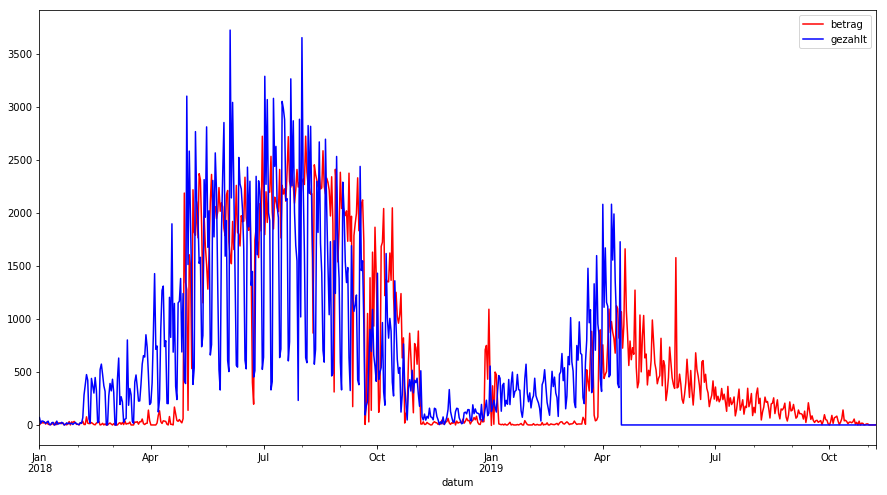

In [7]:
plt.figure(figsize=(15, 8))
ax = df['betrag'].resample('D').sum().plot(color='red', label='betrag')
ax = df['gezahlt'].resample('D').sum().plot(color='blue', label='gezahlt')
ax.legend()
plt.show()

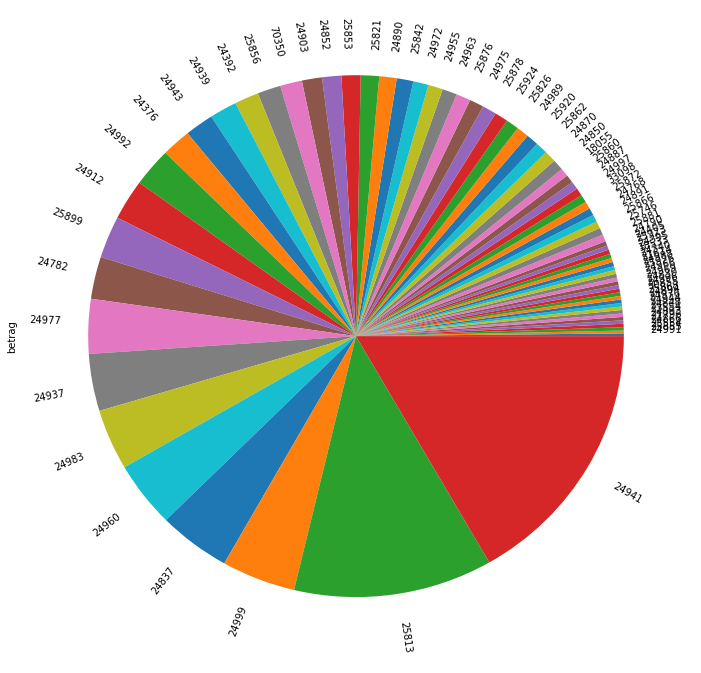

In [8]:
s_umsatz = df.fillna(value={'plz':'XXXXX'}).groupby('plz')['betrag'].sum().fillna(0.0)
s_umsatz.sort_values().plot(kind='pie', legend=False, rotatelabels=True, figsize=(12, 12));

In [9]:
df_plz = pd.read_csv(PLZGEODATEN, sep=';', dtype='str', encoding='latin-1').set_index('Plz')

In [10]:
df_plz['betrag'] = s_umsatz

In [11]:
df_plz.head()

,Ort,Longitude,Latitude,betrag
Plz,,,,
01067,Dresden,51.06,13.7211,NaN
01069,Dresden,51.0396,13.7389,NaN
01097,Dresden,51.0667,13.744,NaN
01099,Dresden,51.0926,13.829,NaN
01109,Dresden,51.1201,13.762,NaN


In [12]:
df_plz_u = df_plz[~df_plz.betrag.isnull()]

In [13]:
df_plz_u.to_csv(KUNDENGEOUMSATZ, sep=';', index=False, header=None)

# Deutschlandkarte vorbereiten


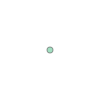

In [14]:
# Geodaten Flensburg
# Breitengrad, Längengrad
Point(9.4469964, 54.7937431)

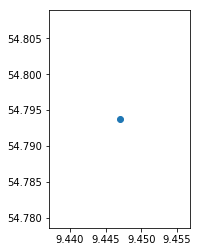

In [15]:
# Geodaten Flensburg

gdf_p = gpd.GeoDataFrame(['flensburg'], geometry=[Point(9.4469964, 54.7937431)])
gdf_p.plot();

In [16]:
world = gpd.read_file(str(MAPDATA))

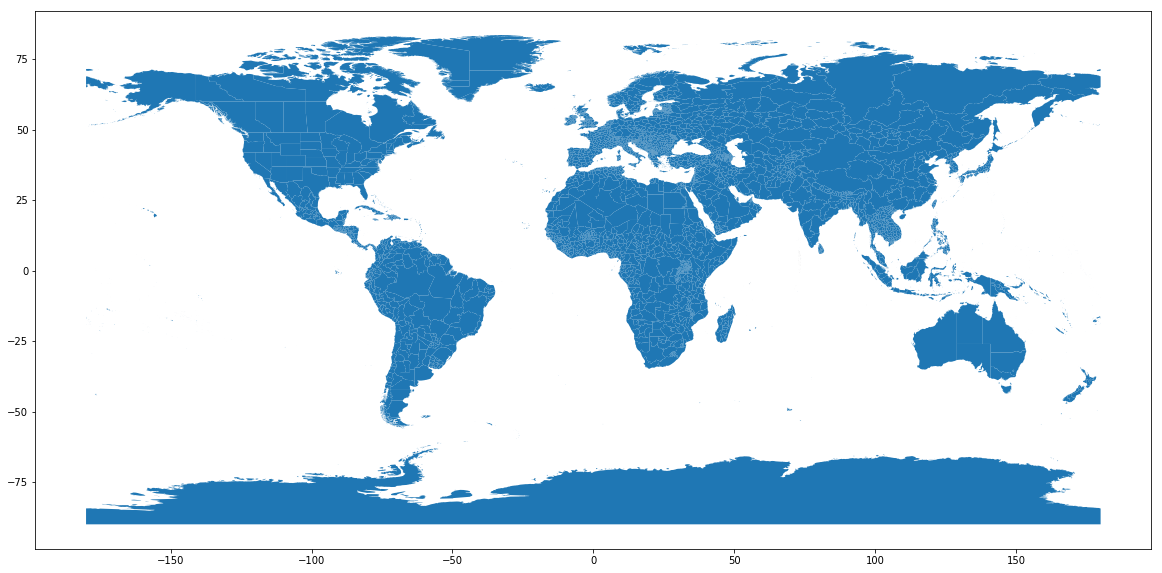

In [17]:
fig, ax = plt.subplots(figsize=(20,20))
world.plot(ax=ax)

In [18]:
# Exkurs: Projektion (Coordinate Reference Systems - CRS) WGS84 Latitude/Longitude

world.crs

{'init': 'epsg:4326'}

In [19]:
gdf_ger = world[world['iso_a2'].isin(['DE'])]

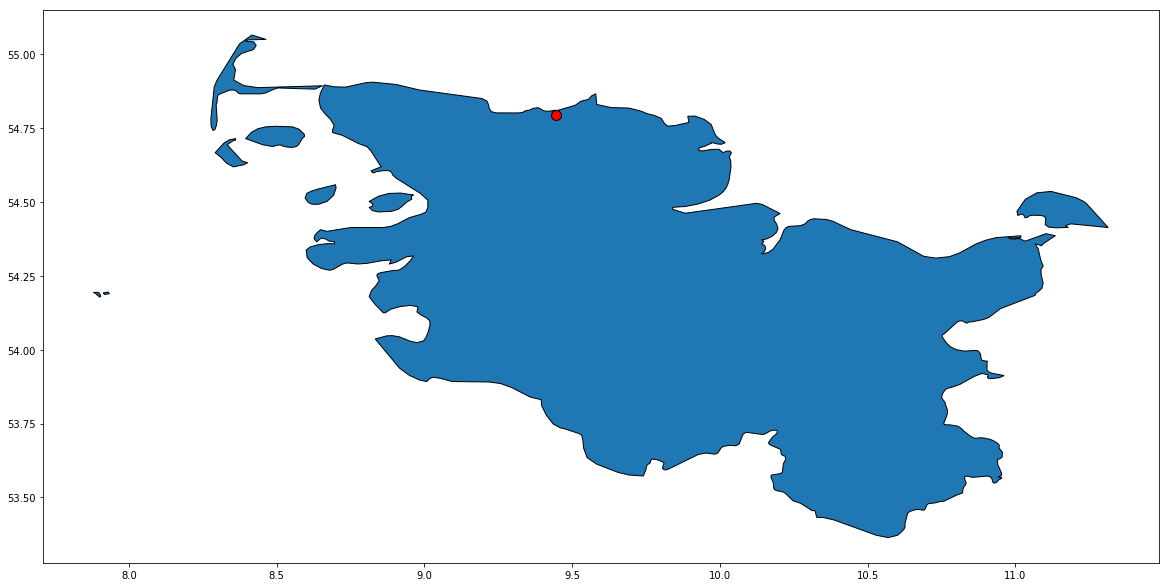

In [20]:
fig, ax = plt.subplots(figsize=(20,20))
gdf_ger[gdf_ger.name=='Schleswig-Holstein'].plot(ax=ax, edgecolor="black")
gdf_p.plot(ax=ax, markersize=100, color='red', edgecolor='black');

In [21]:
gdf_ger_box = gpd.GeoDataFrame(
# [ 5.85248987 47.27112091 15.02205937 55.06533438]
# add some border    
[box(5.3, 46.7, 15.5, 55.5)],
    columns = ['geometry'],
    geometry='geometry',
crs = gdf_ger.crs)

gdf_ger_inv = gpd.tools.overlay(gdf_ger, 
                                gdf_ger_box, 
                                how="symmetric_difference")


# Umsätze ins Grid laden


In [22]:
gdf_grid = gpd.read_file(str(GRIDFILE))

In [23]:
dfu = pd.read_csv(KUNDENGEOUMSATZ, sep=';', header=None)
dfu.columns = 'ort', 'lat', 'lon', 'sum'

In [24]:
gdfu = gpd.GeoDataFrame(dfu, geometry=[Point(x,y) for x,y in zip(dfu.lon, dfu.lat)])

In [25]:
spatial_index = gdfu.sindex

In [26]:
sum_hex = []
for index, row in tqdm(gdf_grid.iterrows()):
    polygon = row.geometry
    possible_matches_index = list(spatial_index.intersection(polygon.bounds))
    possible_matches = gdfu.iloc[possible_matches_index]
    precise_matches = possible_matches[possible_matches.within(polygon)]
    sum_hex.append(sum(precise_matches['sum']))

7127it [00:21, 336.36it/s]


In [27]:
gdf_grid.loc[:,'sum'] = sum_hex

In [28]:
gdf_grid_filtered = gdf_grid[gdf_grid['sum'] > 0.0]

In [29]:
# levels = [0, 1, 1000, 10000, 25000, 50000, 100000, 500000, 1000000]
# colors = ['black', 'darkgrey', 'grey', 'yellow', 'green', 'red', 'orange', 'white']
# cmap, norm =  matplotlib.colors.from_levels_and_colors(levels, colors)

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))
fig.set_facecolor('grey')
ax.set_aspect('equal')

# gdf_grid.plot(ax=ax, column='sum', edgecolor='none', cmap='hot', linewidth=0.001, legend=True)

gdf_ger_box.plot(ax=ax, edgecolor='black', color='black', facecolor=None)

# gdf_grid_filtered.plot(ax=ax, column='sum', edgecolor='face', cmap=cmap, norm=norm, linewidth=1)

gdf_grid_filtered.plot(ax=ax, column='sum', edgecolor='face', cmap='hot', linewidth=1, legend=True)

gdf_ger.plot(ax=ax, color="none", edgecolor='white')
gdf_ger_inv.plot(ax=ax, edgecolor='white', alpha=1.0)

ax.set_ylim([49 ,55.2])
ax.set_xlim([8, 12])
;


''